## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

***
## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


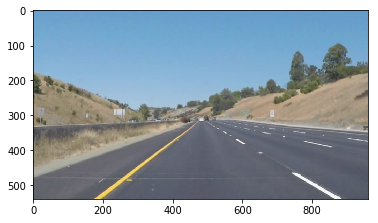

In [2]:
# Reading in an image
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')

# Printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

***
## Test Images

In [3]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg']

***
## Helper Function

The following draw_lines function was altered, sothat it would split up the image in to a left and right half and then find lines with the according algebraic sign 

In [4]:
# Most of there functions were already defined, the draw_lines functions was improved

import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):


    # Declaring variables
    x_l = []
    y_l = []
    
    x_r = []
    y_r = []
    
    # Returning number if dimensions
    split = img.shape

    # For each lane marking seperate image in to left and right side
    for line in lines:
        for x1,y1,x2,y2 in line:
            if x1< split[1]/2 and x2< split[1]/2:
                # left side 
                x_l += [x1, x2]
                y_l += [y1, y2]
            else:
                # right side
                x_r += [x1, x2]
                y_r += [y1, y2]
            
    if len(x_l) != 0 and len(y_l) != 0:
        # Average slope m and y-intercept b on the left - slope of left lane markings is negative
        m,b = np.polyfit(x_l, y_l, 1)
        min_x = min(x_l)
        max_x = max(x_l)
        # Intepolating between x1=(y_max-b)/m, y1=y_max to x2=x_max, y2=m*x_max + b
        cv2.line(img, (int((split[0]-b)/m), split[0]), (max_x, int(max_x * m + b)), color, thickness)

    if len(x_r) != 0 and len(y_r) != 0:
        # Average slope m and y-intercept b on the left - slope of right lane markings is positive
        m,b = np.polyfit(x_r, y_r, 1)
        min_x = min(x_r)
        max_x = max(x_r)
        # Interpolating between x1=x_min, y1=(x_min*m)+b to x2=(y_max-b)/m, y2=y_max
        cv2.line(img, (min_x, int(min_x * m + b)), (int((split[0]-b)/m), split[0]), color, thickness)

    for line in lines:
        # Iterate over all lines
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def select_color(img, rgb_threshold):
    """Applies color selection and return a new image
    This is used for optional challenge"""
    color_selected = np.copy(img)
    thresholds = (img[:, :, 0] < rgb_threshold[0]) \
               | (img[:, :, 1] < rgb_threshold[1]) \
               | (img[:, :, 2] < rgb_threshold[2])
    color_selected[thresholds] = [0, 0, 0]
    return color_selected

***
## Build a Lane Finding Pipeline

### My Approach

1. Define all the necessary parameters
2. Define the pipeline as a function to return final image with lines
3. Iterate over all images and plot them to validate
4. Save images in folder 'test_images_output'

#### 1. Definition of necessary parameters

In [5]:
# Enable average drawing
enable_average_drawing = True

# Define parameters for color selection in bonus task
red_threshold = 215
green_threshold = 180
blue_threshold = 0
rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Define paramaeters for canny edge detection
low_threshold = 50
high_threshold = 150

# Define parameters for hough transform
rho = 1
theta = 1 * np.pi/180
threshold = 25
min_line_len = 20
max_line_gap = 100

# Define parameters for region masking
x_size = image.shape[1]
y_size = image.shape[0]
top_left = [0.45 * x_size, 0.6 * y_size]
top_right = [0.55 * x_size, 0.6 * y_size]
bottom_left = [0, y_size]
bottom_right = [x_size, y_size]
mask_vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)

#### 2. Definition of the pipeline as a function to return final image with lines

In [6]:
def lane_line(img):
    color_selected_img = select_color(img, rgb_threshold)
    canny_img = canny(color_selected_img, low_threshold, high_threshold)
    masked_img = region_of_interest(canny_img, mask_vertices)
    line_img = hough_lines(masked_img, rho, theta, threshold, min_line_len, max_line_gap)
    drawn_img = weighted_img(line_img, img)
    
    return drawn_img

#### 3. Iteration over all images and plot them to validate

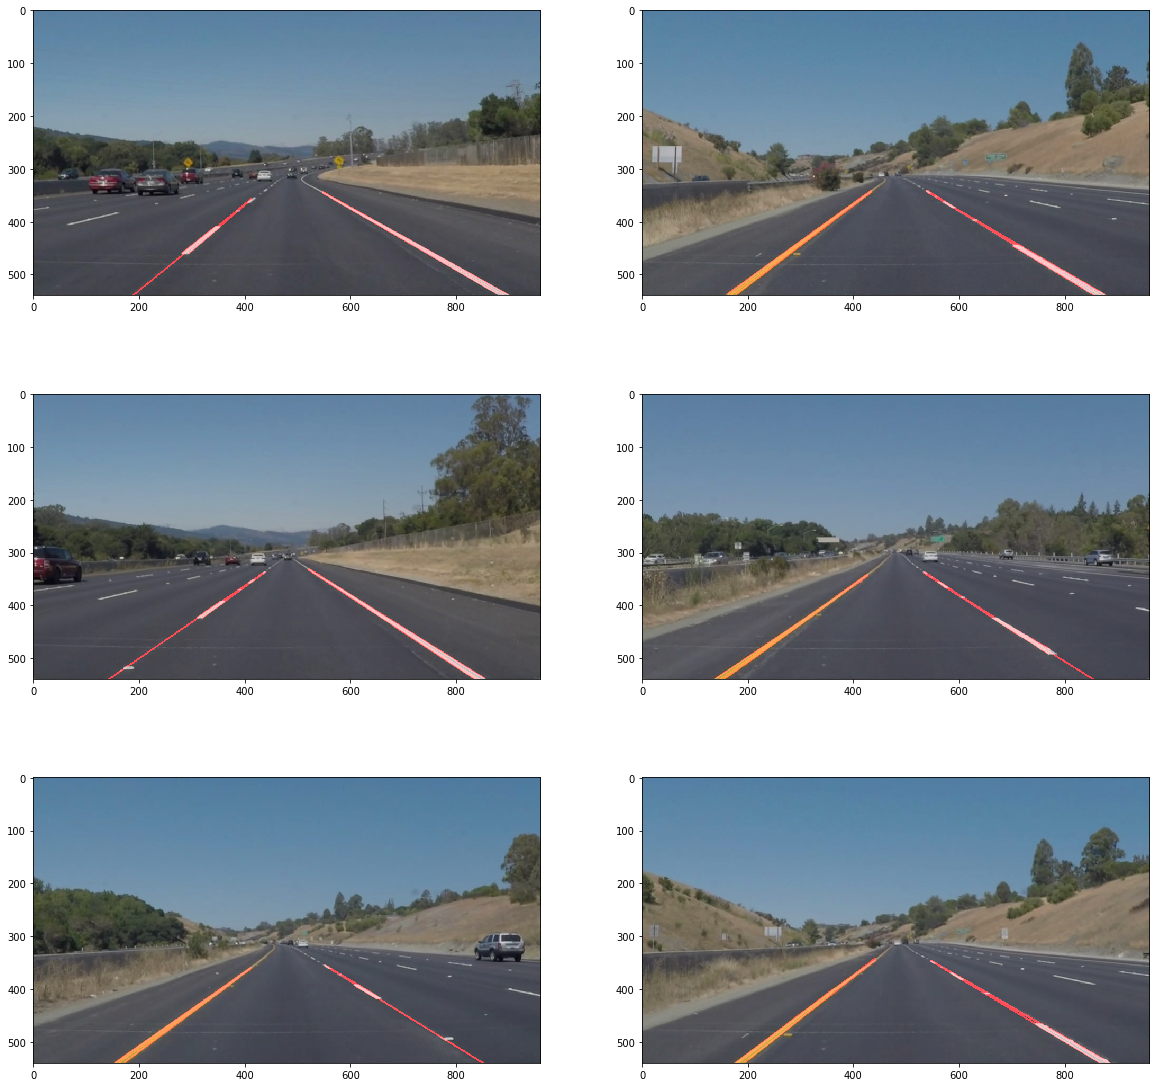

In [7]:
files = os.listdir("test_images/")
drawn_images = [
    (file, lane_line(mpimg.imread('test_images/' + file)))
    for file in files
]

# Plot processed images in a subplot
f, axes = plt.subplots(3, 2, figsize=(20, 20))
for index, (file, img) in enumerate(drawn_images):
    axes[index//2, index % 2].imshow(img)

#### 4. Saving of images in folder 'test_images_output'

In [8]:
# Create folder for image output
if not os.path.isdir("test_images_output"):
    os.mkdir("test_images_output")
    
# Saving of images
for file, img in drawn_images:
    cv2.imwrite('test_images_output/' + file, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

***
## Test on Videos

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### My Approach

1. Apply grayscale on image
2. Apply Gaussian blur on image
3. Apply Canny Edge detection on image
4. Define a polygon to mask the image
5. Apply Hough Transform
6. Write Video File 

In [10]:
# Method of image processing did not work here, therefor there variables are defined within the function, maybe could be done more elegantly
def process_image(image):
    color_select= np.copy(image)
    line_image= np.copy(image)
    
    # Grayscale image
    gray_image = grayscale(color_select)
    
    ysize = image.shape[0]
    xsize = image.shape[1]
    
    # Apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray_image, kernel_size)

    # Apply Canny Edge
    low_threshold = 50
    high_threshold = 150
    edges_image = canny(blur_gray, low_threshold, high_threshold)

    # Create masking polygon
    imshape = color_select.shape
    vertices = np.array([[(50,imshape[0]),(445, 325), (500, 325), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges_image = region_of_interest(edges_image, vertices)

    # Apply Hough Transform
    rho = 2 # Distance resolution in pixels of the Hough grid
    theta = np.pi/180 # Angular resolution in radians of the Hough grid
    threshold = 25     # Minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 # Minimum number of pixels making up a line
    max_line_gap = 100    # Maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # Creating a blank to draw lines on

    # Draw Lines
    
    line_image = hough_lines(masked_edges_image, rho, theta, threshold, min_line_length, max_line_gap)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((edges_image, edges_image, edges_image)) 
    
    return weighted_img(line_image,image)

#### Writing Video files
Apply function to solidWhiteRight.mp4 and open file

In [11]:
white_output = 'test_videos_output/solidWhiteRight.mp4'

# Create test video output directory, if not existent
if not os.path.isdir("test_videos_output"):
    os.mkdir("test_videos_output")

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:13<00:00, 15.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.1 s, sys: 187 ms, total: 3.28 s
Wall time: 14.8 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Apply function to solidYellowLeft.mp4 and open file

In [13]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:45<00:00, 14.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.86 s, sys: 587 ms, total: 10.5 s
Wall time: 47.1 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

# Discussion

## Potential Shortcomings

The current algorithm is not applicable to a variety of cases such as curves or not centered lane markings.
The position of the street horizon is fixed, which may not be usabe for slopes (up and down).
Moreover it is prone to identifying noise as lane markings and therefor making unusable results for some cases.

## Possible Improvements

In a real world scenario, car sensors such as steering angle, translational and rotational acceleration and GPS data could be used to get more information about the shape of the road ahead. This could for instance give data about the slope (GPS) or curvature (steering) ahead. The masking could be adjusted to shift the upper edge according the the slope (up/down) or curve (left/right).
An imporved model could consider specific color ranges only for the lane markings (white, yellow, ...) additional to the edge detection. By that, noise such as trees, other cars or cracks in the street would not be considered as lane markings/lines.